# Sparse Ordinary Autoencoder

From an example on the [Keras blog](https://blog.keras.io/building-autoencoders-in-keras.html), but with sparsity added.

In [83]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.regularizers import Regularizer
from keras import backend as K

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
batch_size = 256
epochs = 50

# p * log(p / p_hat) + (1-p) * log( (1-p) / (1-p_hat) )
def kl_divergence(kl_term, p, p_hat):
    #return (p * (K.log(p) - K.log(1e-10 + p_hat))) + ( (1-p) * (K.log(1-p) - K.log(1e-10 + 1-p_hat)))
    return (kl_term - p * K.log(1e-10 + p_hat) - (1-p) * K.log(1e-10 + 1-p_hat))

class SparseActivityRegularizer(Regularizer):

    def __init__(self, p=0.1, sparsityBeta=3.0):
        self.p = p
        self.sparsityBeta = sparsityBeta
        self.kl_term = p * K.log(p) + (1-p) * K.log(1-p);

    def __call__(self, x):
        regularization = 0.0

        p_hat = K.mean(x, axis=0)
        regularization += self.sparsityBeta * K.sum(kl_divergence(self.kl_term, self.p, p_hat))

        return regularization

    def get_config(self):
        return {"name": self.__class__.__name__} 

# this is our input placeholder
input_img = Input(shape=(784,))
# regularizer (in part-based p=0.05 and beta=3.0, here p=0.01 and beta=6.0 is used...)
#regularizer = SparseActivityRegularizer(0.01, 6.0)
regularizer = regularizers.l1(10e-8)
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizer)(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_37 (Dense)             (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [84]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [85]:
#autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [86]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


(60000, 784)
(10000, 784)


In [87]:
autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 70us/step - loss: 0.3646 - val_loss: 0.2747
Epoch 2/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.2693 - val_loss: 0.2611
Epoch 3/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.2520 - val_loss: 0.2406
Epoch 4/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.2321 - val_loss: 0.2215
Epoch 5/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.2157 - val_loss: 0.2074
Epoch 6/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.2039 - val_loss: 0.1974
Epoch 7/50
60000/60000 [==============================] - 4s 64us/step - loss: 0.1951 - val_loss: 0.1895
Epoch 8/50
60000/60000 [==============================] - 4s 61us/step - loss: 0.1880 - val_loss: 0.1832
Epoch 9/50
60000/60000 [==============================] - 4s 62us/step - loss: 0.1821 - val_loss: 0.1779
Epoch

In [88]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

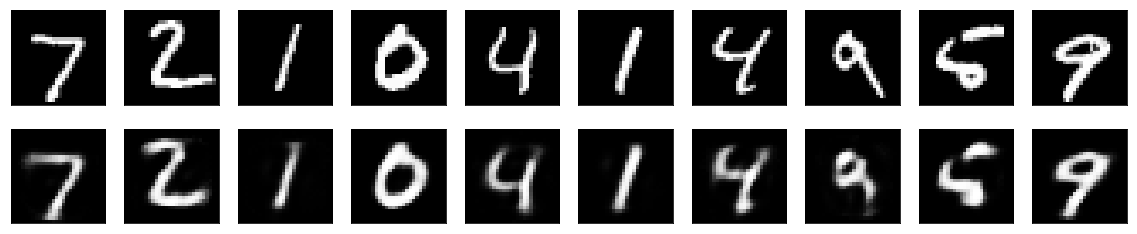

In [89]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

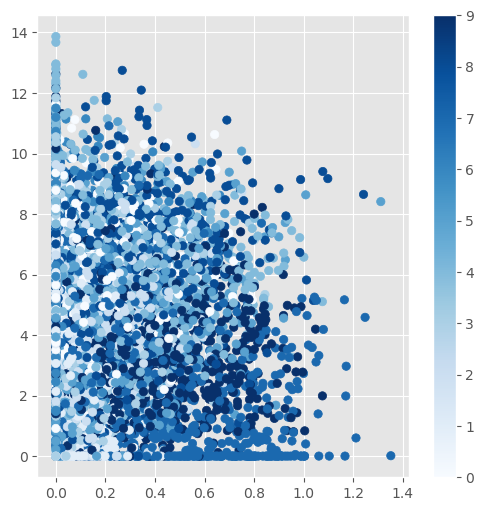

In [90]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

with plt.style.context(['default','ggplot'], after_reset=True):
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='Blues')
    plt.colorbar()
    plt.show()

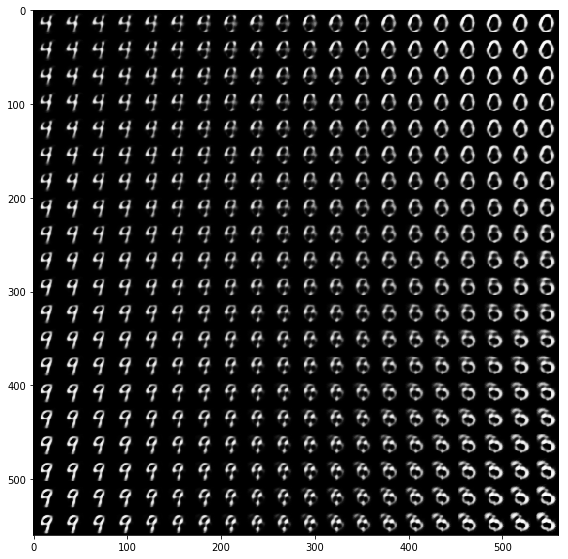

In [91]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

#z_mu_base = np.random.rand(1, encoding_dim);

z_select = np.arange(encoding_dim)
np.random.shuffle(z_select)

z_mu_all = encoder.predict(x_test)
z_mu_base0 = np.reshape(z_mu_all[z_select[0]], (1, encoding_dim))
z_mu_base1 = np.reshape(z_mu_all[z_select[1]], (1, encoding_dim))
z_mu_base2 = np.reshape(z_mu_all[z_select[2]], (1, encoding_dim))
z_mu_base3 = np.reshape(z_mu_all[z_select[3]], (1, encoding_dim))

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        #z_mu = np.array([[xi, yi]]) # only for 2 dim
        # Show interpolations between four randomly chosen digits from the test set 
        z_mu = z_mu_base0 * ((xi + 3)/6)*(1-(yi + 3)/6) + z_mu_base1 * (1-(xi + 3)/6)*((yi + 3)/6)
        z_mu += z_mu_base2 * ((xi + 3)/6)*((yi + 3)/6) + z_mu_base3 * (1-(xi + 3)/6)*(1-(yi + 3)/6)
        x_mean = decoder.predict(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

In [92]:
# The density of the layer with latent variables (not sparse!)
encoded_imgs.mean()

4.985718